In [ ]:
%%capture
!git init
!git pull https://github.com/Leofierus/eeg-alzheimers-detection.git

In [ ]:
%%capture
!pip install mne
!pip install torchviz

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install eeglabio
!conda install -c conda-forge eeglabio

/bin/bash: line 1: conda: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import mne
import os
import warnings
import json
import torch
import torchviz
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchviz import make_dot
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, roc_auc_score

# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [ ]:
def load_eeg_data(file_path):
    raw = mne.io.read_raw_eeglab(file_path)
    return raw.get_data()


class EEGDataset(Dataset):
    def __init__(self, data_directory, dataset):
        self.data_directory = data_directory
        self.dataset = dataset
        labels = [d['label'] for d in dataset]
        self.labels = labels
        data = [d['file_name'] for d in dataset]
        self.data = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        file_info = self.dataset[idx]
        file_path = os.path.join(self.data_directory, file_info['file_name'])

        # Load raw EEG data using MNE
        eeg_data = load_eeg_data(file_path)
        eeg_data = eeg_data.astype('float32')

        # Label
        label = 0 if file_info['label'] == 'A' else 1 if file_info['label'] == 'C' else 2
        # print(f'Label: {label} ({file_info["label"]})')

        return eeg_data, label

In [ ]:
data_dir = 'model-data'
train_dir = os.path.join(data_dir, 'train')
participants_file = os.path.join(data_dir, 'participants.tsv')


full_path = os.path.join(train_dir, "sub-001_eeg_chunk_4.set")
if not os.path.exists(full_path):
        print(f"⚠️ File sub-063_eeg_chunk_29.set not found in '{train_dir}'! Skipping...")





raw = mne.io.read_raw_eeglab(full_path, preload=False)

raw_2 = raw.copy()
# # Plot EEG signals
# # raw.plot(n_channels=19)

data = raw_2.get_data()  # Shape: (n_channels, n_samples)
sfreq = raw_2.info['sfreq']  # Sampling frequency
ch_names = raw_2.info['ch_names']  # Channel names

print(ch_names)
print(data.shape[1])
print(sfreq)

# print(raw)
# print(raw.info)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
1425
95.0


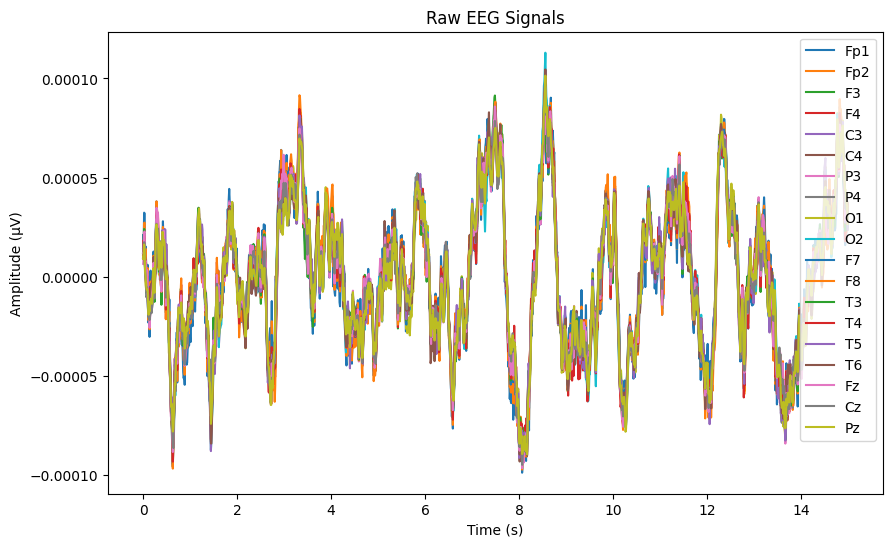

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

time = np.arange(data.shape[1]) / sfreq  # Time axis in seconds
plt.figure(figsize=(10, 6))
for i, ch in enumerate(ch_names):
    plt.plot(time, data[i] , label=ch)  # Offset channels for better visibility
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Raw EEG Signals")
plt.legend(loc="upper right")
plt.show()


In [ ]:
#function will be used later to data augment all files, for now look below for proof of concept

def data_augmentation(directory, expanding_ratio=1):

  try:
        for i, filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                # Perform actions on the file here
                print(f"Processing file: {file_path}")
                jittering(full_path)
                time_masking(full_path)

  except FileNotFoundError:
         print(f"Error: Directory not found: {directory}")
  except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
def time_masking(file_path, w= 0.1):

  w = 0.5 if w > 0.5 else w
  #Getting Data
  if not os.path.exists(full_path):
        print(f"File {full_path} not found! Skipping...")
  raw = mne.io.read_raw_eeglab(full_path, preload=True)

  raw_copy = raw.copy()
  data = raw_copy.get_data()  # Shape: (n_channels, n_samples)



  #modifying data

  starting_point = np.random.randint(data.shape[1]/2)

  end_point = starting_point + int(data.shape[1] * w)
  end_point = min(end_point, data.shape[1])

  print(f"start point is {starting_point}, end point is {end_point}")

  raw_copy._data[:, starting_point:end_point] = 0  # Directly modify MNE's internal data


  #Saving Data

  save_path = "/content/drive/My Drive/EEG_Data_Augmented/Time_Mask/"
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  file_name = os.path.basename(file_path)  # Extracts 'sub-001_eeg_chunk_4.set'
  new_file_name = f"augmented_{file_name}"  # Prepends 'augmented_'
  set_file_path = os.path.join(save_path, new_file_name)

  # Save the EEG data in .SET format
  mne.export.export_raw(set_file_path, raw_copy, fmt = "eeglab", overwrite=True)

  print("EEG .SET file saved to:", set_file_path)





In [ ]:
def jittering(file_path, noise_fraction=0.1):


  #Getting Data
  if not os.path.exists(full_path):
        print(f"File {full_path} not found! Skipping...")
  raw = mne.io.read_raw_eeglab(full_path, preload=True)

  raw_copy = raw.copy()
  data = raw_copy.get_data()


  #modifying data

  std_dev = np.std(data, axis = 1, keepdims=True)


  noise_level = noise_fraction * std_dev

  noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
  raw_copy._data += noise  # Apply jittering

  #Saving Data

  save_path = "/content/drive/My Drive/EEG_Data_Augmented/Jittering/"
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  file_name = os.path.basename(file_path)  # Extracts 'sub-001_eeg_chunk_4.set'
  new_file_name = f"augmented_{file_name}"  # Prepends 'augmented_'
  set_file_path = os.path.join(save_path, new_file_name)

  # Save the EEG data in .SET format
  mne.export.export_raw(set_file_path, raw_copy, fmt = "eeglab", overwrite=True)

  print("EEG .SET file saved to:", set_file_path)





In [ ]:
jittering(full_path,1)
time_masking(full_path)


EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Jittering/augmented_sub-001_eeg_chunk_4.set
start point is 178, end point is 320
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_sub-001_eeg_chunk_4.set


In [ ]:
data_augmentation(train_dir)

Streaming output truncated to the last 5000 lines.
Processing file: model-data/train/sub-077_eeg_chunk_38.set
start point is 436, end point is 578
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_sub-077_eeg_chunk_38.set
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Jittering/augmented_sub-077_eeg_chunk_38.set
Processing file: model-data/train/sub-034_eeg_chunk_28.set
start point is 681, end point is 823
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_sub-034_eeg_chunk_28.set
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Jittering/augmented_sub-034_eeg_chunk_28.set
Processing file: model-data/train/sub-010_eeg_chunk_61.set
start point is 387, end point is 529
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_sub-010_eeg_chunk_61.set
EEG .SET file saved to: /content/drive/My Drive/EEG_Data_Augmented/Jittering/augmented_sub-010_eeg_ch

In [ ]:
file_path = "/content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_time_masking_eeg.set"

raw_modified = mne.io.read_raw_eeglab(file_path, preload=False)

data = raw_modified.get_data()  # Shape: (n_channels, n_samples)

print(ch_names)
zeros = 0
for i in data[0]:
  if i == 0:
    zeros+= 1
#check if values were masked
print(zeros)








['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
142


Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
2


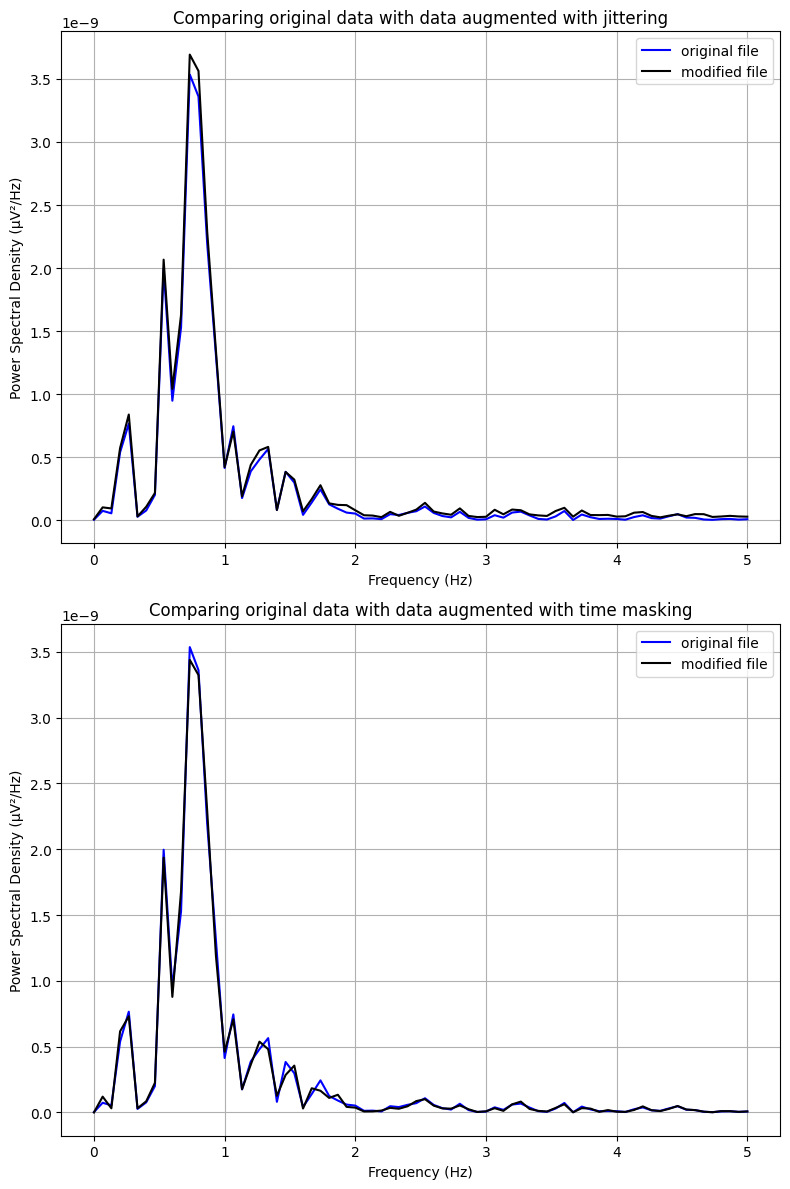

In [ ]:

# 📌 Specific participant pairs for comparison
selected_pairs = [
    ("/content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_jittering_eeg.set", full_path),  # Most different pair
    ("/content/drive/My Drive/EEG_Data_Augmented/Time_Mask/augmented_time_masking_eeg.set", full_path),  # Most different pair
]

# 📌 Function to Load EEG Data and Compute PSD
def load_psd(full_path):
    if not os.path.exists(full_path):
        return None, None

    try:
        raw = mne.io.read_raw_eeglab(full_path, preload=True)
        psd = raw.compute_psd(fmax=5).get_data()  # Compute PSD up to 5 Hz
        freqs = raw.compute_psd(fmax=5).freqs  # Frequency bins
        return freqs, np.mean(psd, axis=0)  # Mean across all channels
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None, None

# 📊 Compute PSD for Selected Individuals
psd_data = {}
for file_pair in selected_pairs:
    for file in file_pair:
        if file not in psd_data:
            freqs, psd_vals = load_psd(file)
            if psd_vals is not None:
                psd_data[file] = (freqs, psd_vals)

print(len(selected_pairs))
# 🎨 Plot PSD Comparison for the Selected Individuals
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

titles = ["Comparing original data with data augmented with jittering", "Comparing original data with data augmented with time masking"]
colors = ["black", "blue"]

for i, (file1, file2) in enumerate(selected_pairs):
    if file1 in psd_data and file2 in psd_data:
        freqs1, psd1 = psd_data[file1]
        freqs2, psd2 = psd_data[file2]

        axes[i].plot(freqs2, psd2, label="original file", color=colors[1])
        axes[i].plot(freqs1, psd1, label="modified file", color=colors[0])

        axes[i].set_xlabel("Frequency (Hz)")
        axes[i].set_ylabel("Power Spectral Density (µV²/Hz)")
        axes[i].set_title(titles[i])
        axes[i].legend()
        axes[i].grid()

plt.tight_layout()
plt.show()
